# Botnet flow and profiling

In [1]:
# IMPORTS"
%matplotlib inline 
from pprint import pprint
from collections import Counter
import random
import time
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import islice
from collections import defaultdict

In [67]:
scenario_10 = 'scenario10.labeled'


def parse_line(split_line):
    src = split_l[3].split(':')
    dst = split_l[5].split(':')

    return {
        'datetime': split_l[0],
        'duration': split_l[1],
        'protocol': split_l[2],
        'src_ip': src[0],
        'src_port': '' if len(src) == 1 else src[1],
        'dst_ip': dst[0],
        'dst_port': '' if len(dst) == 1 else src[1],
        'flags': split_l[6],
        'tos': split_l[7],
        'packets': int(split_l[8]),
        'bytes': int(split_l[9]),
        'flows': split_l[10],
        'label': split_l[11][:-1]
    }

parsed = []
with open('Data/{}'.format(scenario_10)) as f:                                
    next(f) # Skip header
    for idx, l in enumerate(f):
        try:
            split_l = list(filter(None, l.split('\t')))
            parsed.append(parse_line(l))
        except Exception as e:
#             print('ERROR on line {}, raw string {}, splitted as {}'.format(idx, l, split_l))
            try:
#                 print('Attempting to pars with space as dividing character...')
                split_l = list(filter(None, l.split(' ')))
                split_l[0:2] = [' '.join(split_l[0:2])] # Merge date and time again
                parsed.append(parse_line(l))
            except Exception as e:
                print('Final ERROR, skipping line, splitted as {}, error {}'.format(split_l, e))

In [68]:
pprint(parsed[-1])

{'bytes': 17998,
 'datetime': '2011-08-18 15:04:59.743',
 'dst_ip': '147.32.84.21',
 'dst_port': '80',
 'duration': '0.001',
 'flags': 'PA_',
 'flows': '1',
 'label': 'Background',
 'packets': 14,
 'protocol': 'TCP',
 'src_ip': '64.174.237.178',
 'src_port': '80',
 'tos': '0'}


In [69]:
scenario_data = pd.DataFrame.from_records(parsed)
scenario_data['datetime'] = pd.to_datetime(scenario_data['datetime'])
scenario_data.set_index(['datetime'], inplace=True)
scenario_data

,bytes,dst_ip,dst_port,duration,flags,flows,label,packets,protocol,src_ip,src_port,tos
datetime,,,,,,,,,,,,
2011-08-18 10:19:13.328,321,212.24.150.110,33426,0.002,FRPA_,1,Background,4,TCP,147.32.86.166,33426,0
2011-08-18 10:19:13.328,40095,147.32.84.59,41915,4.995,INT,1,Background,617,UDP,82.39.2.249,41915,0
2011-08-18 10:19:13.329,1909200,82.39.2.249,43087,4.996,INT,1,Background,1290,UDP,147.32.84.59,43087,0
2011-08-18 10:19:13.330,66,147.32.192.34,42020,0.000,A_,1,Background,1,TCP,147.32.86.166,42020,0
2011-08-18 10:19:13.330,169,147.32.86.166,25443,0.000,FPA_,1,Background,2,TCP,212.24.150.110,25443,0
2011-08-18 10:19:13.333,1658,147.32.84.2,49190,4.185,A_,1,Background,25,TCP,115.184.37.24,49190,0
2011-08-18 10:19:13.335,70580,147.32.86.24,51287,4.978,PA_,1,Background,311,TCP,80.78.79.156,51287,0
2011-08-18 10:19:13.335,64319,151.41.188.39,31002,4.978,INT,1,Background,292,UDP,147.32.86.24,31002,0
2011-08-18 10:19:13.336,145,147.32.84.118,39051,0.000,INT,1,Background,1,UDP,82.73.244.56,39051,0


## Task 3

We aim to learn a sequential model from NetFlow data from an infected host (unidirectional netfows). Consider scenario 10 from the CTU-13 data sets (see paper 4 from below resources). Remove all background flows from the data. You are to discretize the NetFlows. Investigate the data from one of the infected hosts. Select and vizualize two features that you believe are most relevant for modeling the behavior of the infected host. Discretize these features using use any of the methods discussed in class (combine the two values into a single discrete value). Do you observe any behavior in the two features that could be useful for detecting the infection? Explain. Apply the discretization to data from all hosts in the selected scenario.

- Infected hosts
    - 147.32.84.165: Windows XP English version Name: SARUMAN. Label: Botnet. Amount of bidirectional flows: 9579
    - 147.32.84.191: Windows XP English version Name: SARUMAN1. Label: Botnet. Amount of bidirectional flows: 10454
    - 147.32.84.192: Windows XP English version Name: SARUMAN2. Label: Botnet. Amount of bidirectional flows: 10397
    - 147.32.84.193: Windows XP English version Name: SARUMAN3. Label: Botnet. Amount of bidirectional flows: 10009
    - 147.32.84.204: Windows XP English version Name: SARUMAN4. Label: Botnet. Amount of bidirectional flows: 11159
    - 147.32.84.205: Windows XP English version Name: SARUMAN5. Label: Botnet. Amount of bidirectional flows: 11874
    - 147.32.84.206: Windows XP English version Name: SARUMAN6. Label: Botnet. Amount of bidirectional flows: 11287
    - 147.32.84.207: Windows XP English version Name: SARUMAN7. Label: Botnet. Amount of bidirectional flows: 10581
    - 147.32.84.208: Windows XP English version Name: SARUMAN8. Label: Botnet. Amount of bidirectional flows: 11118
    - 147.32.84.209: Windows XP English version Name: SARUMAN9. Label: Botnet. Amount of bidirectional flows: 9894
- Normal hosts:
    - 147.32.84.170 (amount of bidirectional flows: 10216, Label: Normal-V42-Stribrek)
    - 147.32.84.134 (amount of bidirectional flows: 1091, Label: Normal-V42-Jist)
    - 147.32.84.164 (amount of bidirectional flows: 3728, Label: Normal-V42-Grill)
    - 147.32.87.36 (amount of bidirectional flows: 99, Label: CVUT-WebServer. This normal host is not so reliable since is a webserver)
    - 147.32.80.9 (amount of bidirectional flows: 651, Label: CVUT-DNS-Server. This normal host is not so reliable since is a dns server)
    - 147.32.87.11 (amount of bidirectional flows: 4, Label: MatLab-Server. This normal host is not so reliable since is a matlab server)

ToS = Type of Service

#### Infected - from host

In [70]:
# Get all data from the first infected host

# Infected from Thu Aug 18 11:06:10 CEST 2011
infected_host_ip = '147.32.84.165'

src_infected_host_data = scenario_data.loc[scenario_data['src_ip'] == infected_host_ip]
not_yet_infected = src_infected_host_data.loc['2011-08-18 00:00:00':'2011-08-18 11:06:09']
print(not_yet_infected.shape)
not_yet_infected

(22, 12)


,bytes,dst_ip,dst_port,duration,flags,flows,label,packets,protocol,src_ip,src_port,tos
datetime,,,,,,,,,,,,
2011-08-18 10:37:58.448,64,147.32.80.9,1025,0.000,INT,1,Botnet,1,UDP,147.32.84.165,1025,0
2011-08-18 10:38:00.695,87,147.32.80.9,1025,0.000,INT,1,Botnet,1,UDP,147.32.84.165,1025,0
2011-08-18 10:38:00.706,629,74.125.232.206,1027,0.043,SRPA_,1,Botnet,4,TCP,147.32.84.165,1027,0
2011-08-18 10:38:03.255,76,147.32.80.9,1025,0.000,INT,1,Botnet,1,UDP,147.32.84.165,1025,0
2011-08-18 10:38:03.267,180,65.55.56.40,123,2.990,INT,1,Botnet,2,UDP,147.32.84.165,123,0
2011-08-18 10:44:50.523,60,147.32.96.45,21,0.000,RA_,1,Botnet,1,TCP,147.32.84.165,21,0
2011-08-18 10:44:52.019,60,147.32.96.45,21,0.000,RA_,1,Botnet,1,TCP,147.32.84.165,21,0
2011-08-18 10:44:55.518,60,147.32.96.45,21,0.000,RA_,1,Botnet,1,TCP,147.32.84.165,21,0
2011-08-18 10:44:57.020,60,147.32.96.45,21,0.000,RA_,1,Botnet,1,TCP,147.32.84.165,21,0


In [71]:
infected = src_infected_host_data.loc['2011-08-18 14:30:09':'2011-08-19 14:31:00']
print(infected.shape)
infected

(4331, 12)


,bytes,dst_ip,dst_port,duration,flags,flows,label,packets,protocol,src_ip,src_port,tos
datetime,,,,,,,,,,,,
2011-08-18 14:30:19.666,467832,147.32.96.69,1046,4.991,INT,1,Botnet,499,UDP,147.32.84.165,1046,0
2011-08-18 14:30:19.709,394,82.96.64.4,1026,0.911,PA_,1,Botnet,5,TCP,147.32.84.165,1026,0
2011-08-18 14:30:24.671,468824,147.32.96.69,1046,4.992,INT,1,Botnet,500,UDP,147.32.84.165,1046,0
2011-08-18 14:30:29.674,468733,147.32.96.69,1046,4.997,INT,1,Botnet,500,UDP,147.32.84.165,1046,0
2011-08-18 14:30:34.681,468691,147.32.96.69,1046,4.997,INT,1,Botnet,500,UDP,147.32.84.165,1046,0
2011-08-18 14:30:39.688,468645,147.32.96.69,1046,4.997,INT,1,Botnet,500,UDP,147.32.84.165,1046,0
2011-08-18 14:30:44.696,188492,147.32.96.69,1046,2.012,INT,1,Botnet,201,UDP,147.32.84.165,1046,0
2011-08-18 14:30:46.713,363,82.96.64.4,1026,1.046,PA_,1,Botnet,5,TCP,147.32.84.165,1026,0
2011-08-18 14:33:12.739,84,82.96.64.4,1026,0.000,PA_,1,Botnet,1,TCP,147.32.84.165,1026,0


#### Compare - from host

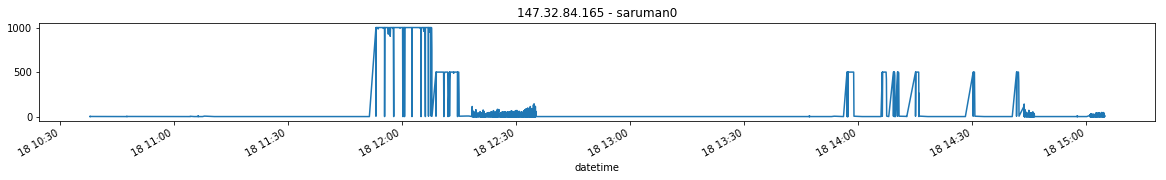

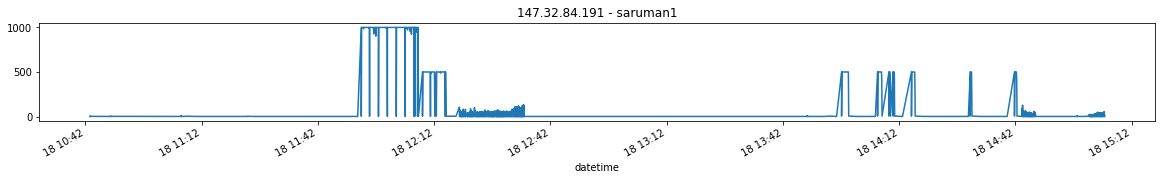

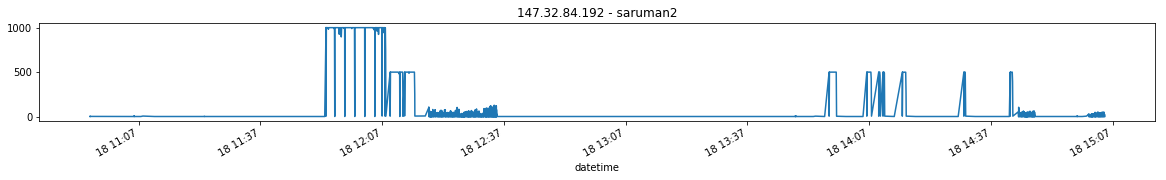

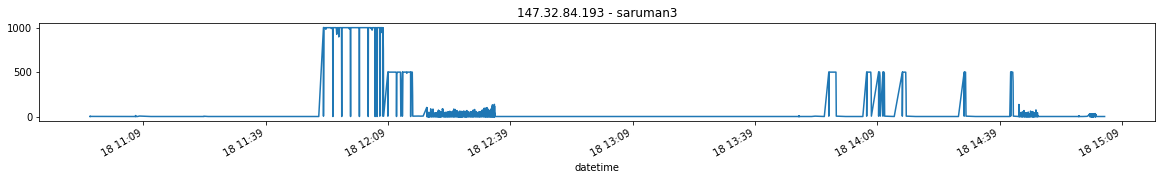

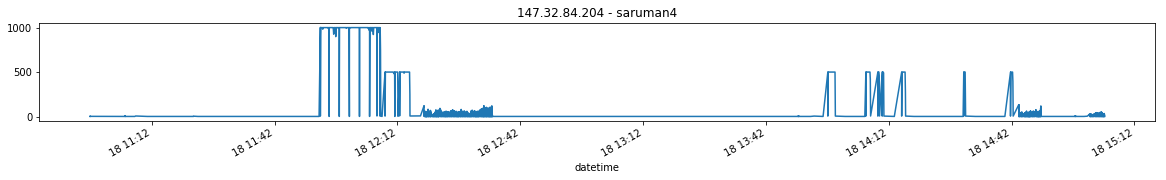

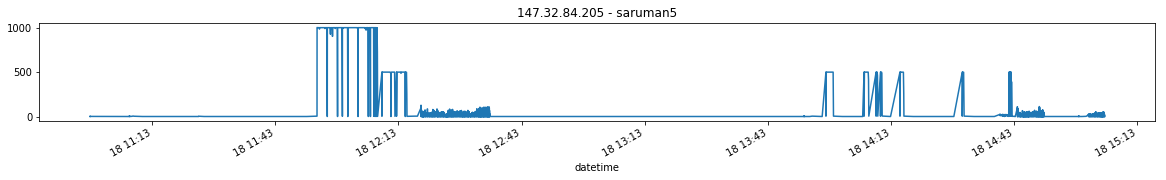

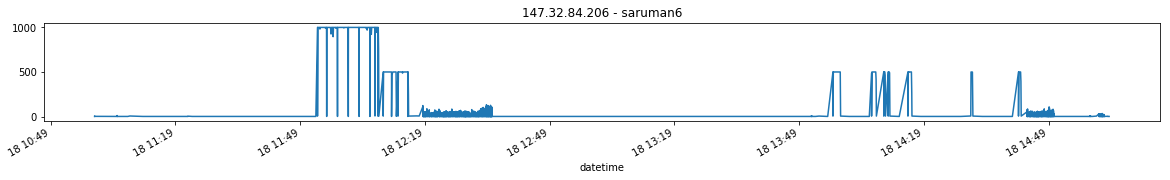

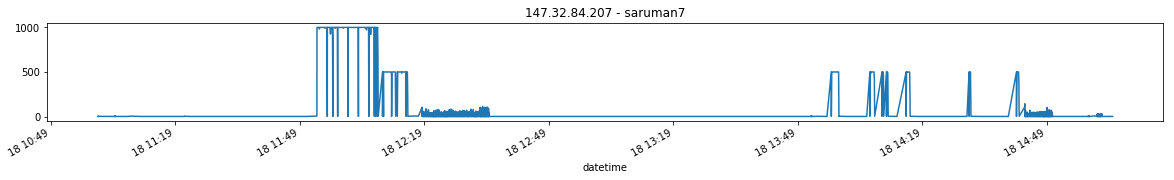

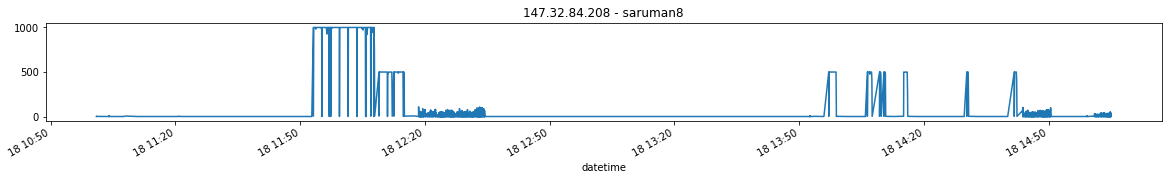

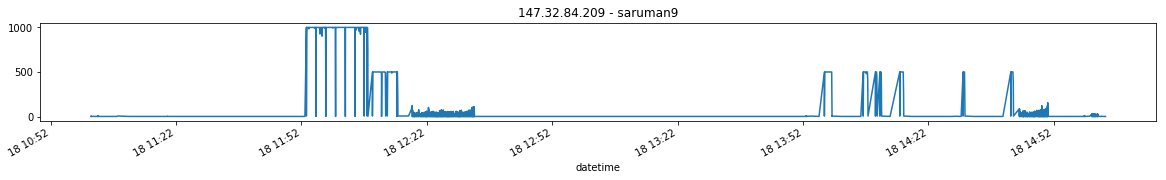

In [72]:
infected_hosts = ['147.32.84.165', '147.32.84.191', '147.32.84.192', '147.32.84.193', '147.32.84.204', '147.32.84.205', 
                 '147.32.84.206', '147.32.84.207', '147.32.84.208', '147.32.84.209']
host_name = ['saruman{}'.format(x) for x in range(0, 10)]

for idx, host in enumerate(infected_hosts):
    host_data = scenario_data.loc[scenario_data['src_ip'] == host] # Only take selected host src
    host_data = host_data[host_data.label != 'Background'] # Drop background
    host_data['packets'].plot(figsize=(20, 2), title='{} - {}'.format(host, host_name[idx]))
    plt.show()

### Normal - from host

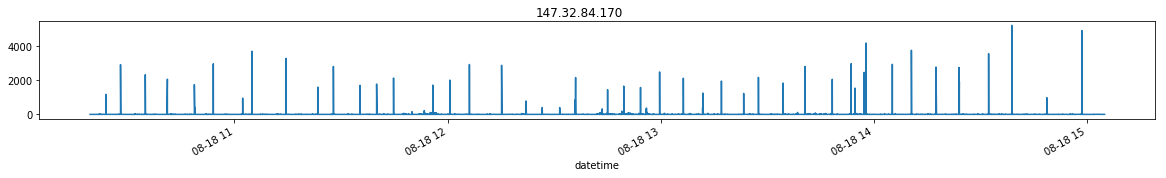

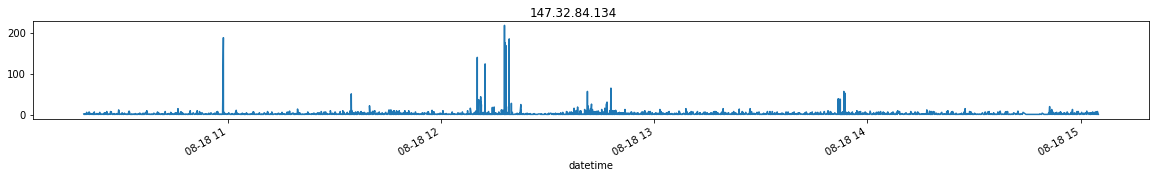

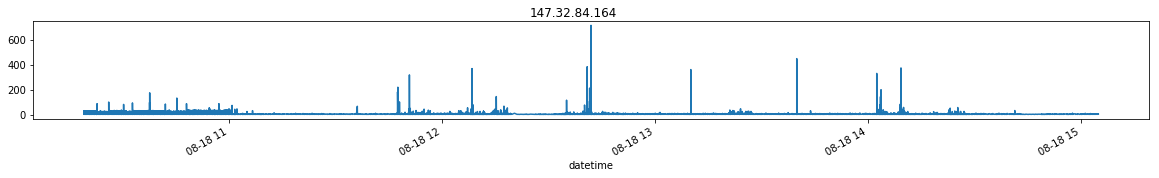

In [73]:
normal_hosts = ['147.32.84.170', '147.32.84.134', '147.32.84.164']

for host in normal_hosts:
    host_data = scenario_data.loc[scenario_data['src_ip'] == host] # Only take selected host src
    host_data = host_data[host_data.label != 'Background'] # Drop background
    host_data['packets'].plot(figsize=(20, 2), subplots=True, title=host)
    plt.show()

### Compare hosts

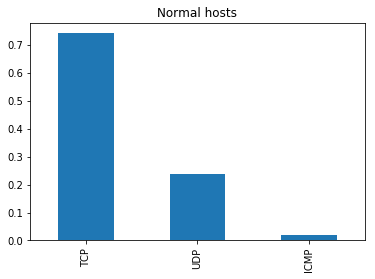

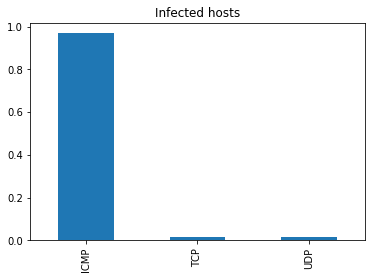

In [74]:
total_normal_hosts_protocol = defaultdict(lambda: 0)
for host in normal_hosts:
    host_data = scenario_data.loc[scenario_data['src_ip'] == host]
    for k, v in host_data['protocol'].value_counts().items():
        total_normal_hosts_protocol[k] += v

total_infected_hosts_protocol = defaultdict(lambda: 0)
for host in infected_hosts:
    host_data = scenario_data.loc[scenario_data['src_ip'] == host]
    for k, v in host_data['protocol'].value_counts().items():
        total_infected_hosts_protocol[k] += v

df_normal = pd.DataFrame(total_normal_hosts_protocol, index=[0])
df_infected = pd.DataFrame(total_infected_hosts_protocol, index=[0])

(df_normal.T / df_normal.T.sum()).plot(kind='bar', title='Normal hosts', legend=False)
(df_infected.T / df_infected.T.sum()).plot(kind='bar', title='Infected hosts', legend=False)

### Discretization

In [75]:
def discretize_continuous_feature(distribution, current_window):
    """
    Discretize a single sliding window using percentiles,
    using the distribution achieved from current_slide
    """
    discretized = []
    for element in current_window:
        if element < distribution[0]:
            discretized.append(0)
        elif element > distribution[1]:
            discretized.append(2)
        else:
            discretized.append(1)
    return discretized

### Attribute mapping

In [90]:
def map_attribute(feature_vec: list, M_i: list):
    """
    Attribute mapping algorithm from Pellegrino et al.
    
    feature_vec: list features, so [(1) protocol, (2) discrete_packets]
    M_i: list of number of values for each feature
    
    """
    space_size = np.prod(M_i)
    code = 0
    
    for i, a_i in enumerate(feature_vec):
        code += a_i * (space_size / M_i[i])
        spaces_size = space_size / M_i[i]
    return code

### Discretize all hosts in "streaming"

/home/y/.local/share/virtualenvs/cyber-data-analytics-nVPvrn_X/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


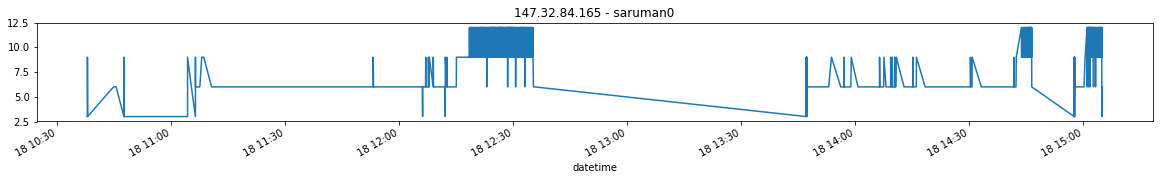

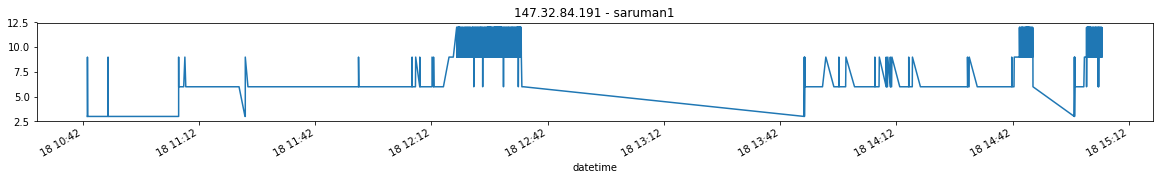

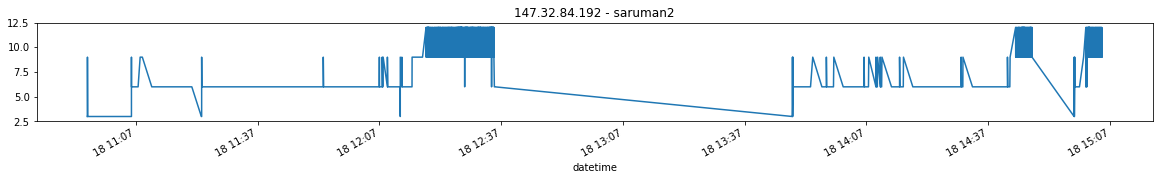

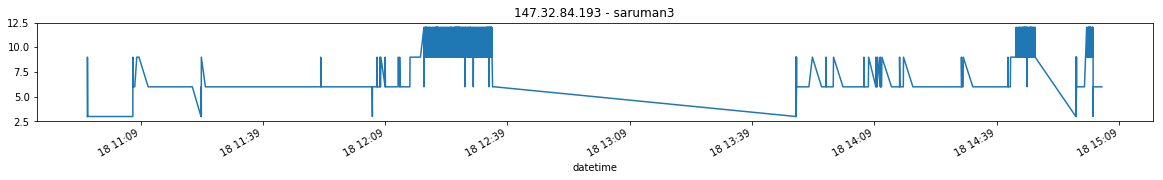

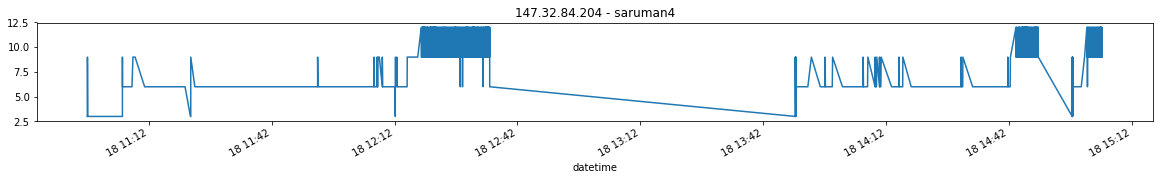

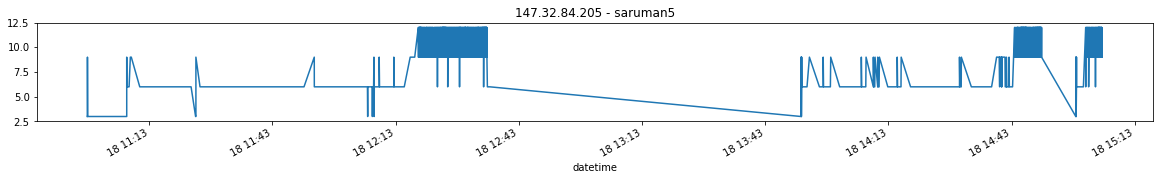

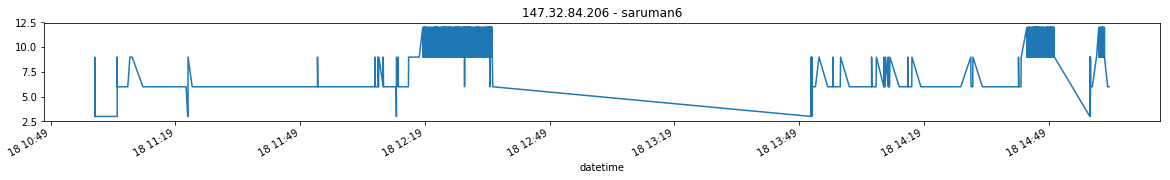

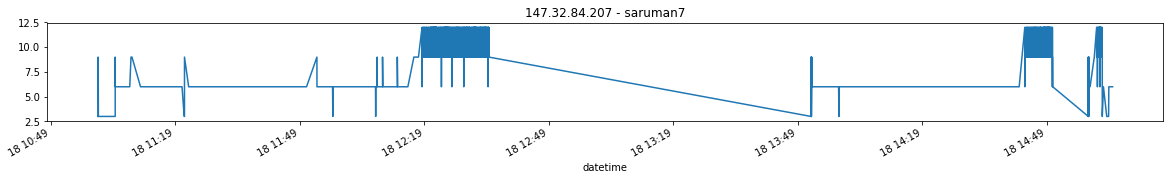

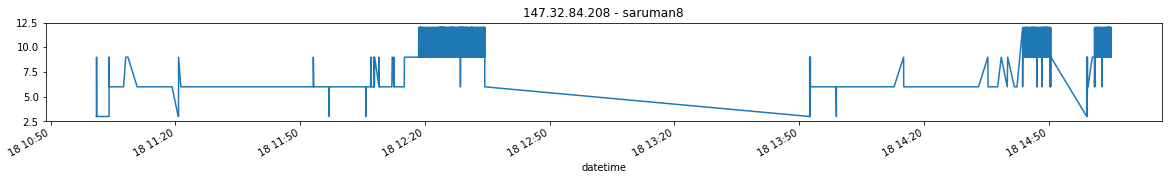

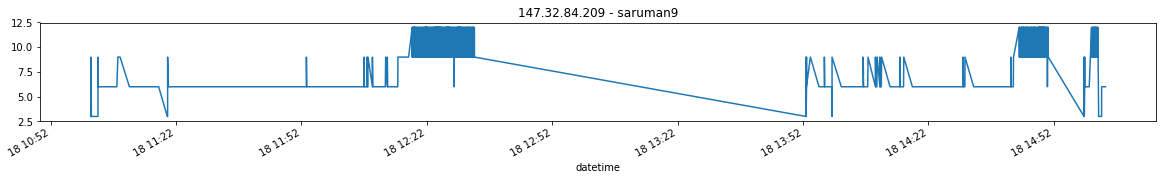

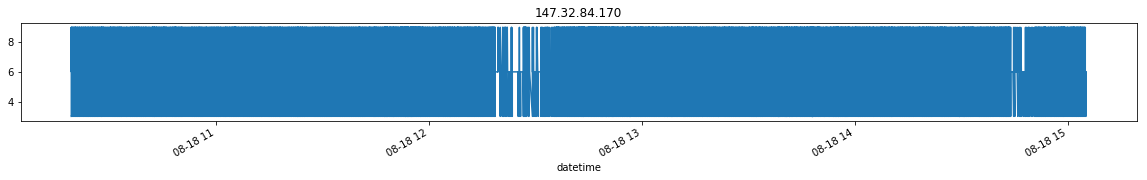

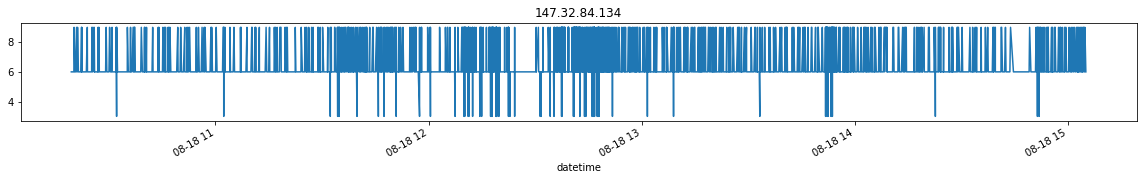

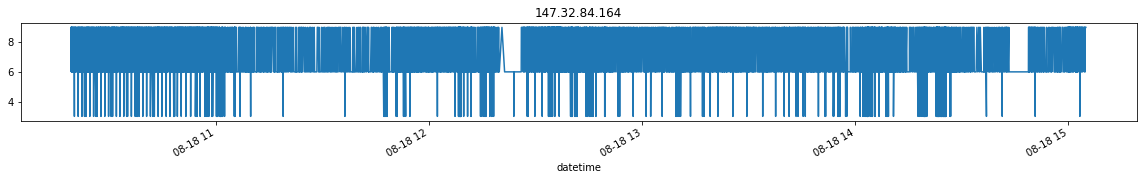

In [100]:
"""
BEGIN PARAMETERS
"""
sliding_window_size = 20
"""
END PARAMETERS
"""

def window(data: pd.DataFrame, size=2):
    """
    Generator for rolling window over dataframe
    """            
    for i in range(len(data)):
        if i + size < len(data):
            yield data[i:i+size]
        else:
            return data[i:i+size]

        
def find_percentiles(data: list) -> dict:
    """
    Find lower and upper percentiles for an array
    """
   
    lower_percentile = (20 / 100) * len(data)
    upper_percentile = (80 / 100) * len(data)
            
    return data[round(lower_percentile)], data[round(upper_percentile)]


def find_n_different_values_discrete(data: list):
    """
    Find the length of a set of the data
    """
    return len(set(data))


# Both features have the same number of feature values
n_different_values = [3, 3]

# Get percentiles from single host
percentiles = find_percentiles(scenario_data.loc[scenario_data['src_ip'] == '147.32.84.165']['packets'])

# Make string values numerical
proto = {'UDP': 0, 'TCP': 1, 'ICMP': 2}

featured_hosts = {}
for idx, host in enumerate(infected_hosts + normal_hosts):
    host_data = scenario_data.loc[scenario_data['src_ip'] == host] # Only take selected host src
    codes_list = []  # Code for each time point
    for row in host_data.itertuples(index=True):
        discrete_n_packet = discretize_continuous_feature(percentiles, [getattr(row, 'packets')])
        code = map_attribute([discrete_n_packet[0], proto[getattr(row, 'protocol')]], n_different_values)
        codes_list.append(code)
    
    # Plot data one host
    host_data['combined_feature'] = codes_list
    try:
        host_data['combined_feature'].plot(figsize=(20, 2), title='{} - {}'.format(host, host_name[idx]))
        plt.show()
    except IndexError as e:
        host_data['combined_feature'].plot(figsize=(20, 2), title='{}'.format(host))
        plt.show()


### Plot discretization

## Task 4

In [79]:
from hmmlearn import hmm

# Learn probablistic model from one infected host
model = hmm.GaussianHMM(n_components=3, covariance_type="full")

for w in window(host_data, sliding_window_size):
    score = model.score(w)
    if score > threshold:
        # mark as not matching profile
        pass
    else:
        # mark as matching profile
        pass

NotFittedError: This GaussianHMM instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.